# 14.38 PS5 
In this problem set I will solve problems 1, 2, and 3 from PM-3

## PM3 Problem 1
In this problem, I will explain random forests and bootstrap aggregation, starting from the basics of regression trees.

The basic idea behind regression trees is that we partition the data into groups in some "good" way (I will talk about what is "good" soon), and then, within each group, take the average of a variable or variables of interest. Then, we use those averages as predictions for new data that falls into our partitions. 

Now we can be more specific. Let's consider a variable of interest $Y$ and a set of covariates $X = (X_1, \ldots, X_n)$. We can then partition the data into groups $R_1, \ldots, R_M$, based on criteria that utilize $X$. Then our prediction rule will take the form

$$ f(x) = \sum_{m=1}^M \beta_m I(x \in R_m) $$

What does this prediction rule mean? For a given vector $x$, we can determine which of our $M$ partitions in which $x$ lies, then our prediction for $\hat{Y} = f(x) = \beta_j$ if $x \in R_j$. When we train our tree, we estimate $\beta_j$ by minimizing least squared errors within the training group, so we find that $\beta_j$ is the average of $Y$ for all the data that lies in $R_j$. 

So, for a given tree structure, it is relatively straightforward to determine our prediction rule. How do we determine the best tree structure? Through cross validation. By separating our data into training and testing groups, we can find, at a given level of the tree, we find the variable and the value at which partitioning the data gives the highest increase in out of sample predictive performance. If, in our current subset of the data, partitioning into college graduates and non-college graduates yields the best out of sample predictive performance, we partition the data into those two groups, then move down to the next level. We can then "prune" the tree by checking to see if removing certain groups improves predictive performance.

Now that we introduced regression trees, we can talk about random forests. Random forests take advantage of a concept called "bootstrap aggregation", known shortly as "bagging". When we are preparing to construct a random forest, we create a number of artifical samples by randomly sampling from our original sample with replacement (this is the "bootstrap" part of "bootstrap aggregation"). Using each of these boostrapped samples, we construct a relatively deep tree. We then average the predictions given by all of these trees. How does this averaging work? For a certain vector of covariates $x$, each tree $i$ will produce a prediction of the form $f_i(x) =\sum_m \beta_m I(x \in R_{mi})$. We can then take the simple average over all our predictions, 

$$\hat{Y} = \frac{1}{n} \sum_i f_i(x)$$
Random forests have many attractive properties. It improves the prediction of a single pruned tree, and we can use randomization to bring more variance into our individual trees, which further improves the prediction by "decorrelating" our individual trees.

## PM3 Problem 2

In this problem, I will (attempt) to explain a basic neural networks. We'll start with a basic single layer network, because the ideas can be easily extended from there. The basic idea behind a neural network is to take your basic features, and pass them into complicated functions to create a handful of technical features. Once you have the technical features, the prediction rule is given by a linear combination, like in linear regression. To represent this mathematically, we say the prediction rule is given by

$$ \hat{g}(Z) = \hat{\beta}'X(\hat{\alpha})$$

where $Z$ is our collection of basic features in the original data, $\hat{\beta}$ is a vector of coefficients, and $X(\hat{\alpha})$ is the collection of technical features. The construction of the technical features are the key to understanding neural networks. Each of these features are called "neurons". These are constructed by plugging in linear combinations of regressors (the linear combinations have a coefficient vector $\hat{\alpha_m}$) into an activation function. Mathematically, we say that for neuron $m$,

$$X_m(\hat{\alpha_m}) = \sigma(\hat{\alpha_m}Z)$$

where $\sigma$ is the activation function of choice. Some examples of activation functions include the sigmoid function and the ReLU (rectified linear unit) function, both shown below.

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.0     ✔ dplyr   1.0.5
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



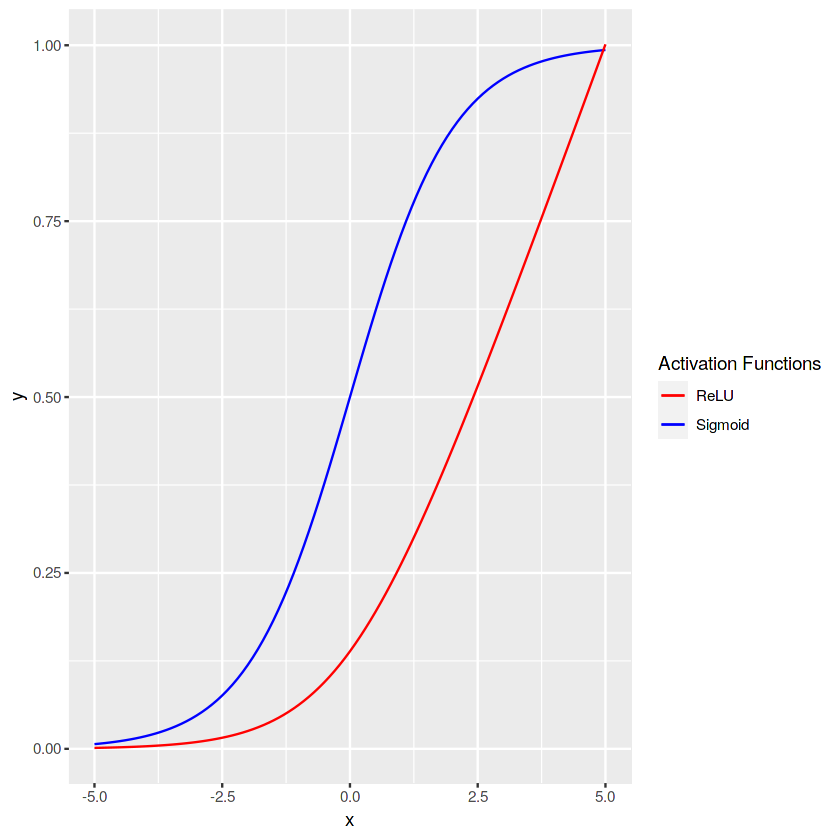

In [3]:
library(tidyverse)

sigmoid <- function(x){1/(1+exp(-x))}
relu <- function(x){0.2*log(1+exp(x))}

func_plot <- ggplot(data.frame(x=0), mapping=aes(x=x)) +
    stat_function(fun = sigmoid, aes(color="Sigmoid")) +
    stat_function(fun = relu, aes(color="ReLU")) +
    scale_x_continuous(limits=c(-5, 5)) + 
    scale_color_manual(name = "Activation Functions", 
                       values = c("red", "blue"))

func_plot

There are other activation functions as well. We could use the linear function for our activation function, but if we did so for all our nodes, that just returns to linear regression.

How are the coefficients $\hat{\alpha}_m$ and $\hat{\beta}$ determined? Generally, the loss function is a penalized least squares function, of the form

$$ \min_{\{\alpha_m\}, \beta} \sum_i \left(Y_i - \sum_{m=1}^M \beta_m X_{im}(\alpha_m) \right)^2 + \text{pen}(\alpha, \beta, \lambda) $$

Where $\text{\pen}(\alpha, \beta, \lambda)$ is some penalization function, like in lasso or ridge regression. Essentially what this means is that our model attempt to minimize least squares, but is also penalized for complexity. In practice, we minimize this very complicated loss function with stochastic gradient descent, which can take a very long time for a large, complicated network.

So, how do we extend this to a "multi-layer network"? We essentially repeat this process, by taking our neurons in the first layer and use them as regressors in the next layer, and so on. Eventually, we arrive at the last letter, where we take our linear combination of technical regressors to find our prediction rule.

## PM-3 Problem 3

In this problem, I will use the "keras" library to construct a neural network that mixes linear and non-linear regression to predict wages. I will compare its performance to a basic linear regression model. First, I will load and prep the data, by splitting into training and testing samples, as well as demeaning and rescaling.

In [4]:
load("../input/wage2015-subsample-inferencerdata/wage2015_subsample_inference.Rdata")
Z <- select(data, -c(lwage, wage))

#sample splitting
set.seed(1)
training <- sample(nrow(data), nrow(data)*(3/4), replace=FALSE)

data_train <- data[training,1:16]
data_test <- data[-training,1:16]

#store mean and std, rescale data
mean <- apply(data_train, 2, mean)
std <- apply(data_train, 2, sd)
data_train <- scale(data_train, center = mean, scale = std)
data_test <- scale(data_test, center = mean, scale = std)
data_train <- as.data.frame(data_train)
data_test <- as.data.frame(data_test)

#store outcome vars
y.train <- data_train$lwage
y.test <- data_test$lwage
Z <- select(data, -c(lwage, wage))

Now we can specify the linear model, estimate it, and store the $R^2$.

In [28]:
#generating basic model
X_basic <- lwage ~ sex + exp1 + shs + hsg+ scl + clg + mw + so + we
basic <- lm(X_basic, data=data_train)
basic.mat <- model.matrix(basic, data=data_train)
basic.mat.test <- model.matrix(basic, data=data_test)

#prediction
basic.predict <- predict(basic, newdata=data_test)

#prediction statistics
basic.MSE <- sum((basic.predict - y.test)^2)/length(y.test)
basic.R2 <- 1 - basic.MSE/var(y.test)

Now that we have our linear model baseline, we can construct a neural network using keras. In our neural network, we will mix linear and non-linear methods a bit. We construct a neural network of 3 layers. In the first layer, we use a linear activation function, so the first layer is essentially just linear regression. The middle layer uses the ReLU activation function and lasso-style regularization. Finally, the third layer also uses linear activation.

In [47]:
library(keras)

build_model <- function() {
  model <- keras_model_sequential() %>% 
    layer_dense(units = 20, 
                input_shape = dim(basic.mat)[2])%>% 
    layer_dense(units = 10, activation = "relu", kernel_regularizer=regularizer_l1(0.001)) %>%
    layer_dense(units = 10) %>%
    layer_dense(units = 1) 
  
  model %>% compile(
    optimizer = optimizer_adam(lr = 0.005),
    loss = "mse", 
    metrics = c("mse")
  )
}

model <- build_model()

# training the network 
num_epochs <- 1000
model %>% fit(basic.mat, y.train, epochs = num_epochs, batch_size = 100)
# evaluating the performnace
model %>% evaluate(basic.mat.test, y.test, verbose = 0)

# Calculating the performance measures
pred.nn <- model %>% predict(basic.mat.test)
MSE.nn = summary(lm((y.test-pred.nn)^2~1))$coef[1:2]
R2.nn <- 1-MSE.nn[1]/var(y.test)

# printing R^2
cat("R^2 of the neural network:",R2.nn)
cat("R^2 of basic linear model:", basic.R2)

loss       mse 
0.7618079 0.7559974

R^2 of the neural network: 0.1932758R^2 of basic linear model: 0.1881207

There are a variety of other networks we can try (and that I did try, when I wrote this notebook), but I can't get performance much better than this network. So, we can improve the predictive performance of the linear model, but only by very little. If we used an AutoML framework, we could likely do better, but I doubt that we could improve on the linear model enough to justify the computational effort we use to train our neural nets.